In [1]:
import scanpy as sc
import glob

In [2]:
import os
os.chdir('/mnt/data3/wangj2/MouseKidney/RData7')

In [3]:
import anndata2ri
from rpy2.robjects import r
from rpy2.robjects.conversion import localconverter
anndata2ri.activate()

/tmp/ipykernel_57688/3569427243.py:4: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [6]:
r('library(Seurat)')

# r(f'x<-load("sce.RData")')
r(f'x<-load("Stromal.RData")')
r('y=get(x)')

r('rm(x)')
r('DefaultAssay(y) <- "RNA"') 
adata = r('as.SingleCellExperiment(y)')

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



In [5]:
# adata.obsm['X_umap'] = r('Embeddings(y,reduction = "umap")')
# adata.obsm['X_pca'] = r('Embeddings(y,reduction = "pca")')
# adata.obsm['X_pca'] = adata.obsm['SCVI'] 

In [7]:
adata = adata[adata.obs.celltype.isin(['Peri','Myo','Fibro'])]
adata 

View of AnnData object with n_obs × n_vars = 675 × 13350
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Condition', 'cellnames', 'pANN_0.25_0.11_561', 'Doublets', 'pANN_0.25_0.01_544', 'pANN_0.25_0.02_678', 'pANN_0.25_0.01_468', 'pANN_0.25_0.01_514', 'pANN_0.25_0.3_667', 'project', 'integrated_snn_res.0.7', 'seurat_clusters', 'celltype', 'nCount_SCT', 'nFeature_SCT', 'RNA_snn_res.0.2', 'ECM_UCell', 'SCENT_score', 'group', 'RNA_snn_res.0.6', 'ident'
    obsm: 'SCVI', 'X_umap'
    layers: 'logcounts'

/home/tools/anaconda3/envs/velocyto-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/tools/anaconda3/envs/velocyto-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


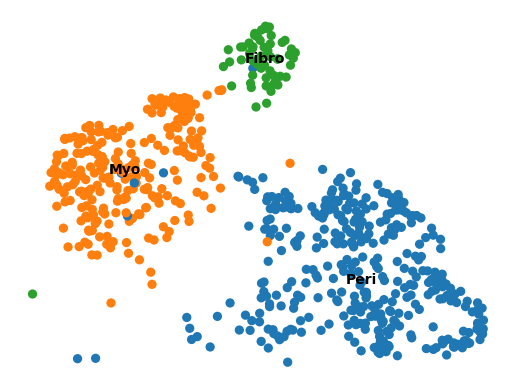

In [8]:
sc.pl.umap(adata, color='celltype', frameon=False, legend_loc='on data', title='')

In [9]:
# RNA-velocity
import scvelo as scv

In [10]:
ldata_raw = scv.read("/mnt/data3/wangj2/MouseKidney/Velo/merged.loom")
ldata_raw

AnnData object with n_obs × n_vars = 56831 × 31053
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [11]:
ldata  = ldata_raw.copy()

In [14]:
### uniform cell ID
cellID = ldata.obs_names.values
cellnames = [s.split(":")[1].replace("x","-1") for s in cellID]
batch = [s.split(":")[0] for s in cellID]
import pandas as pd
batch = pd.DataFrame(pd.Categorical(batch),columns=['batch'])
batch['batch']
batch['batch'].cat.categories = ['_4','_5','_6','_1','_2','_3']
cellID = []
for i,j in zip(cellnames,list(batch['batch'])):
    cellID.append(i+j)
ldata.obs['cellnames'] = cellID
ldata = ldata[ldata.obs.cellnames.isin(adata.obs_names)]
ldata 

View of AnnData object with n_obs × n_vars = 675 × 31053
    obs: 'Clusters', '_X', '_Y', 'cellnames'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [15]:
Sdata=adata[ldata.obs.cellnames]
Sdata.obs_names = ldata.obs_names
Sdata

AnnData object with n_obs × n_vars = 675 × 13350
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Condition', 'cellnames', 'pANN_0.25_0.11_561', 'Doublets', 'pANN_0.25_0.01_544', 'pANN_0.25_0.02_678', 'pANN_0.25_0.01_468', 'pANN_0.25_0.01_514', 'pANN_0.25_0.3_667', 'project', 'integrated_snn_res.0.7', 'seurat_clusters', 'celltype', 'nCount_SCT', 'nFeature_SCT', 'RNA_snn_res.0.2', 'ECM_UCell', 'SCENT_score', 'group', 'RNA_snn_res.0.6', 'ident'
    uns: 'celltype_colors'
    obsm: 'SCVI', 'X_umap'
    layers: 'logcounts'

In [16]:
Sdata = scv.utils.merge(Sdata, ldata)
Sdata

AnnData object with n_obs × n_vars = 675 × 13345
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Condition', 'cellnames', 'pANN_0.25_0.11_561', 'Doublets', 'pANN_0.25_0.01_544', 'pANN_0.25_0.02_678', 'pANN_0.25_0.01_468', 'pANN_0.25_0.01_514', 'pANN_0.25_0.3_667', 'project', 'integrated_snn_res.0.7', 'seurat_clusters', 'celltype', 'nCount_SCT', 'nFeature_SCT', 'RNA_snn_res.0.2', 'ECM_UCell', 'SCENT_score', 'group', 'RNA_snn_res.0.6', 'ident', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'celltype_colors'
    obsm: 'SCVI', 'X_umap'
    layers: 'logcounts', 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [191]:
# velocyto matrix
# cell_use = ldata.obs.cellnames.values
# ldata.obs['Condition'] = adata[cell_use,:].obs['Condition'].values
# ldata.obs['orig.ident'] = adata[cell_use,:].obs['orig.ident'].values
# ldata.obs['celltype'] = adata[cell_use,:].obs['celltype_fine'].values
# ldata.obs['batch'] = adata[cell_use,:].obs['orig.ident'].values
# Sdata = ldata.copy()

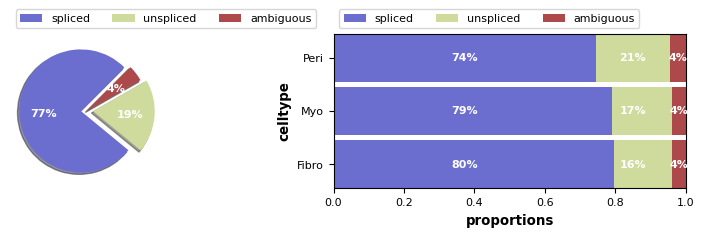

In [17]:
# os.chdir('/home/wangjing2/wangj2/codebase/MouseKidney/Figures')
scv.pl.proportions(Sdata,groupby='celltype',dpi=100,layers=['spliced','unspliced','ambiguous'])

In [18]:
Group = []
for i in range(0,Sdata.shape[0]):
    Group.append(Sdata.obs['celltype'][i] +'_' + Sdata.obs['Condition'][i])
Sdata.obs['Group'] = pd.Categorical(Group)

In [110]:
### calculate velocity graph
import numpy as np
SSdata = Sdata.copy()

In [111]:
ECM_genes = pd.read_excel('/home/wangjing2/wangj2/codebase/MouseKidney/ECMgenes.xlsx',sheet_name='Sheet1')
ECM_genes = ECM_genes[ECM_genes['Species'] == 'MOUSE']
ECM_genes = ECM_genes['Gene Symbol'].values
ECM_genes = [s for s in ECM_genes if s in SSdata.var_names]
ECM_genes 

['Abi3bp',
 'Aebp1',
 'Agrn',
 'Bmper',
 'Cilp',
 'Ctgf',
 'Dpt',
 'Ecm1',
 'Efemp1',
 'Efemp2',
 'Eln',
 'Emid1',
 'Emilin1',
 'Emilin2',
 'Fbln1',
 'Fbln1',
 'Fbln2',
 'Fbln5',
 'Fbn1',
 'Fbn1',
 'Fbn2',
 'Fga',
 'Fgb',
 'Fgg',
 'Fn1',
 'Fndc1',
 'Fras1',
 'Gldn',
 'Hmcn1',
 'Hmcn2',
 'Igfbp6',
 'Igfbp7',
 'Igsf10',
 'Kcp',
 'Lama1',
 'Lama2',
 'Lama3',
 'Lama4',
 'Lama5',
 'Lamb1',
 'Lamb2',
 'Lamc1',
 'Lamc1',
 'Lamc2',
 'Lamc3',
 'Lrg1',
 'Ltbp1',
 'Ltbp2',
 'Ltbp3',
 'Ltbp4',
 'Matn2',
 'Mfap2',
 'Mfap4',
 'Mfap5',
 'Mfge8',
 'Mgp',
 'Mmrn2',
 'Ndnf',
 'Nid1',
 'Nid2',
 'Npnt',
 'Npnt',
 'Npnt',
 'Ntn1',
 'Ntn4',
 'Pcolce',
 'Pcolce2',
 'Postn',
 'Postn',
 'Pxdn',
 'Sbspon',
 'Sparc',
 'Spon1',
 'Srpx',
 'Srpx2',
 'Tgfbi',
 'Thbs1',
 'Thbs2',
 'Thbs3',
 'Thbs4',
 'Thsd4',
 'Tinag',
 'Tinagl1',
 'Tnc',
 'Tnc',
 'Tnn',
 'Tnxb',
 'Tnxb',
 'Vtn',
 'Vwa1',
 'Vwa5a',
 'Col10a1',
 'Col11a1',
 'Col12a1',
 'Col13a1',
 'Col13a1',
 'Col14a1',
 'Col15a1',
 'Col15a1',
 'Col15a1',
 'Col16a1',


In [112]:
SSdata.raw = SSdata
SSdata = SSdata[:,ECM_genes]
SSdata

View of AnnData object with n_obs × n_vars = 675 × 129
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Condition', 'cellnames', 'pANN_0.25_0.11_561', 'Doublets', 'pANN_0.25_0.01_544', 'pANN_0.25_0.02_678', 'pANN_0.25_0.01_468', 'pANN_0.25_0.01_514', 'pANN_0.25_0.3_667', 'project', 'integrated_snn_res.0.7', 'seurat_clusters', 'celltype', 'nCount_SCT', 'nFeature_SCT', 'RNA_snn_res.0.2', 'ECM_UCell', 'SCENT_score', 'group', 'RNA_snn_res.0.6', 'ident', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'Group'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'celltype_colors'
    obsm: 'SCVI', 'X_umap'
    layers: 'logcounts', 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [113]:
scv.pp.filter_and_normalize(SSdata)

Normalized count data: spliced, unspliced.


In [107]:
sc.pp.pca(SSdata)
sc.pp.neighbors(SSdata)
sc.tl.umap(SSdata)
scv.pp.moments(SSdata)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'stochastic', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 5/64 cores)
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [ ]:

scv.tl.velocity(SSdata,'stochastic')
scv.tl.velocity_graph(SSdata,n_jobs=5)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


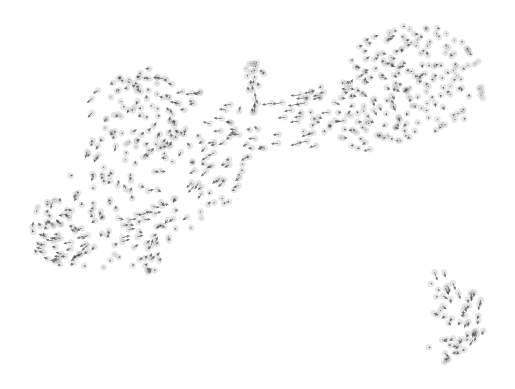

In [108]:
scv.pl.velocity_embedding(SSdata, basis='umap', frameon=False)

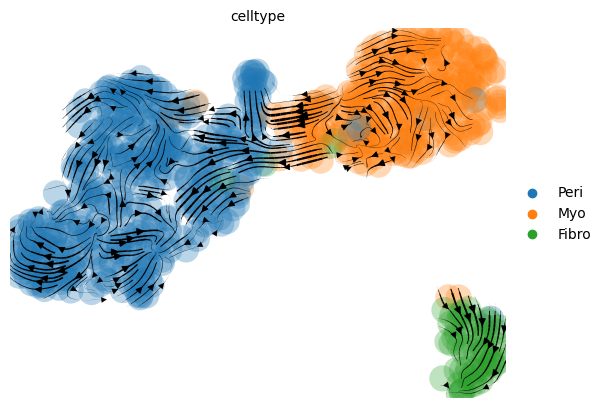

In [109]:
scv.pl.velocity_embedding_stream(SSdata,basis = "umap",color='celltype',density = 3,dpi=100,legend_loc="upper_right")

In [87]:
SSdata

AnnData object with n_obs × n_vars = 675 × 129
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Condition', 'cellnames', 'pANN_0.25_0.11_561', 'Doublets', 'pANN_0.25_0.01_544', 'pANN_0.25_0.02_678', 'pANN_0.25_0.01_468', 'pANN_0.25_0.01_514', 'pANN_0.25_0.3_667', 'project', 'integrated_snn_res.0.7', 'seurat_clusters', 'celltype', 'nCount_SCT', 'nFeature_SCT', 'RNA_snn_res.0.2', 'ECM_UCell', 'SCENT_score', 'group', 'RNA_snn_res.0.6', 'ident', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'Group', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'stochastic_gamma', 'stochastic_qreg_ratio', 'stochastic_r2', 'stochastic_genes', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'celltype_colors', 'pca', 'neighbors', 'umap', 'stochastic_params', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'SCVI', 'X_umap', 'X_pca', 'velocit

/home/wangjing/.local/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


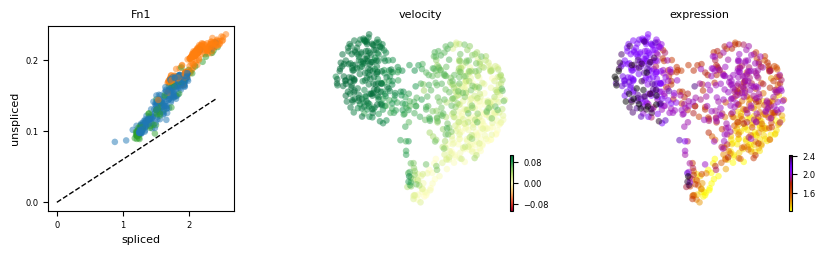

In [86]:
scv.pl.velocity(SSdata, var_names=['Fn1'], color='celltype')

In [226]:
scv.tl.rank_velocity_genes(SSdata, groupby='celltype', min_corr=.3)

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


/home/wangjing/.local/lib/python3.8/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


In [139]:
df = scv.DataFrame(SSdata.uns['rank_velocity_genes']['names'])
df.to_csv('/home/wangjing2/wangj2/codebase/MouseKidney/Stromal_Velo.csv')

/tmp/ipykernel_30563/752425716.py:1: DeprecationWarning: `scvelo.read_load.get_df` is deprecated since scVelo v0.2.4 and will be removed in a future version. Please use `scvelo.core.get_df` instead.
  df = scv.DataFrame(SSdata.uns['rank_velocity_genes']['names'])


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/home/wangjing/.local/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


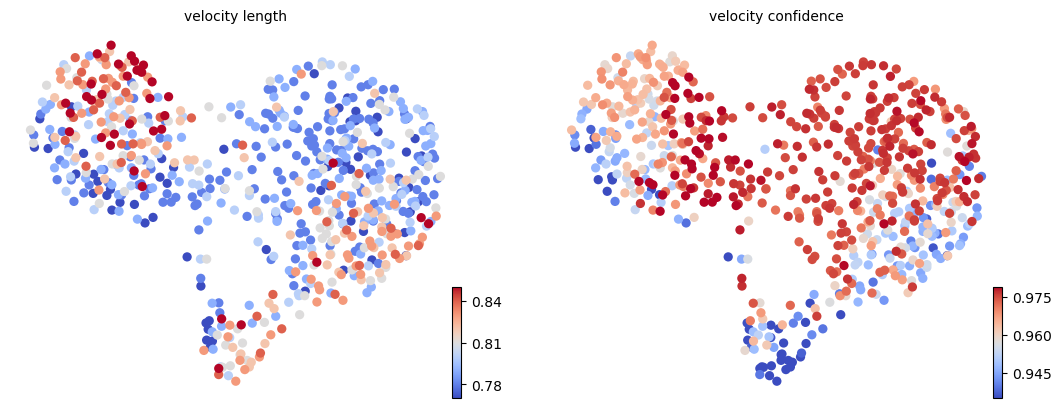

In [227]:
scv.tl.velocity_confidence(SSdata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(SSdata, c=keys, cmap='coolwarm', perc=[5, 95])

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/home/wangjing/.local/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


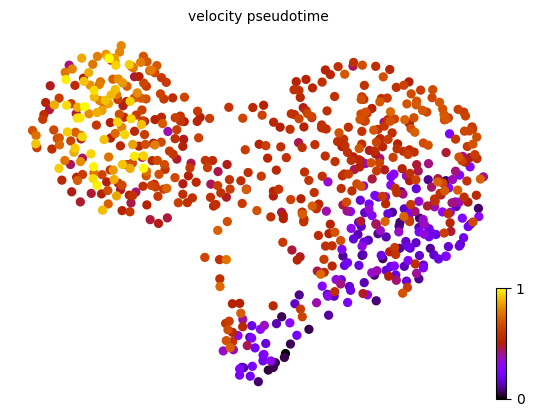

In [228]:
scv.tl.velocity_pseudotime(SSdata)
scv.pl.scatter(SSdata, color='velocity_pseudotime', cmap='gnuplot')